In [98]:
df = pd.read_csv('results.csv')
df

,throw,white,red
0,1,1,1
1,2,2,2
2,3,3,3
3,4,4,4
4,5,5,5
5,6,6,6
6,7,1,1
7,8,2,2
8,9,3,3
9,10,4,4


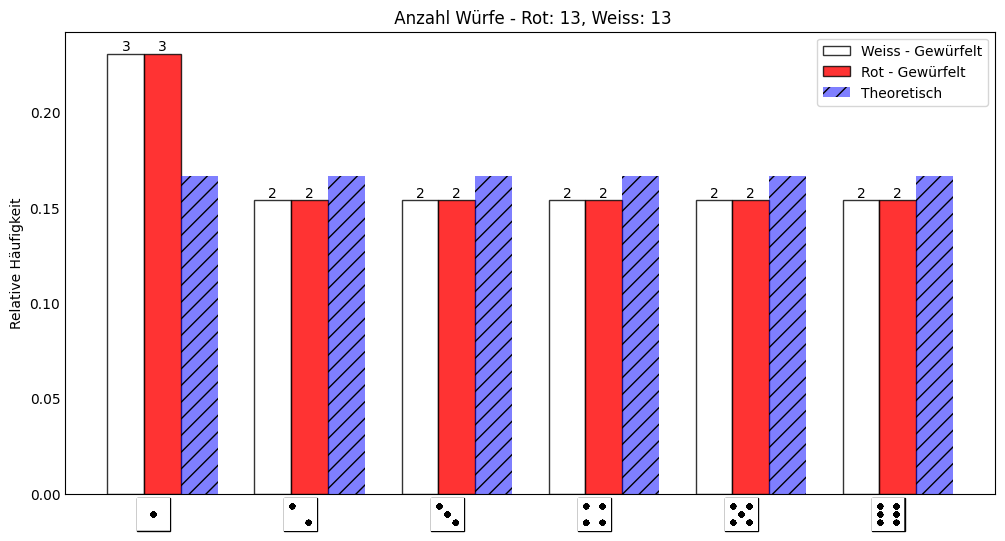

In [99]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.stats import chisquare
from matplotlib.ticker import MaxNLocator

# Lock matplotlib for multithreading
#plt.switch_backend('Agg')
from threading import Lock
matplotlib_lock = Lock()

STATPATH = r'C:\Users\buehl\repos\Dice\dev_app\static'

def place_image(ax, img_path, xy, zoom=1):
    img = plt.imread(img_path)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=True, xybox=(20, -15), boxcoords="offset points", pad=0)
    ax.add_artist(ab)

def plot_histogram(data_path, column_names=['white', 'red']):
    
    german_dict= {'white':'Weiss - Gewürfelt', 'red':'Rot - Gewürfelt'}
    with matplotlib_lock:
        df = pd.read_csv(data_path)
        fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size here
        
        # Set x-axis to integers only
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        # Plot each column's histogram side by side
        bar_width = 0.25
        for i, column_name in enumerate(column_names):
            rolls = df[column_name].dropna().tolist()
            if len(rolls) != 0:
                # Calculate observed frequencies and p-value
                observed_frequencies = [rolls.count(i) / len(rolls) for i in range(1, 7)]
                
                # Plot bar chart for observed frequencies
                ax.bar([x + i * bar_width for x in range(1, 7)], 
                       observed_frequencies, 
                       alpha=0.8, label=german_dict[column_name], width=bar_width,
                       edgecolor='black',
                       color='red' if column_name == 'red' else 'white')
                
                # Annotate each bar with the actual count for each outcome
                for x, freq in zip(range(1, 7), observed_frequencies):
                    ax.text(x + (i * bar_width), freq + 0.0, f'{rolls.count(x)}', ha='center', va='bottom')

        # Plot theoretical probabilities (shared between both columns)
        theoretical_probs = [1/6] * 6
        ax.bar([x + len(column_names) * bar_width for x in range(1, 7)], 
               theoretical_probs, 
               alpha=0.5, label=f'Theoretisch', width=bar_width,
               color='blue', hatch='//')

        # Remove numerical x-tick labels and place images instead
        ax.set_xticks([1 + i * bar_width + len(column_names) * bar_width / 2 for i in range(6)])
        ax.set_xticklabels([])  # Remove x-tick labels
        ax.tick_params(axis='both', which='both', length=0)  # Remove axis ticks

        for i in range(1, 7):
            place_image(ax, os.path.join(STATPATH, f'side{i}.jpg'), xy=(i, 0), zoom=0.04)
            
        len_white = len(df['white'].dropna().tolist())
        len_red = len(df['red'].dropna().tolist())
        
        plt.title(f' Anzahl Würfe - Rot: {len_white}, Weiss: {len_red}')
        plt.ylabel('Relative Häufigkeit')
        plt.legend()
        plt.show()
        
        
        # img = BytesIO()
        # plt.savefig(img, format='png')
        # img.seek(0)
        # plt.close()
        # return img

# Example usage:
plot_histogram('results.csv', ['white', 'red'])



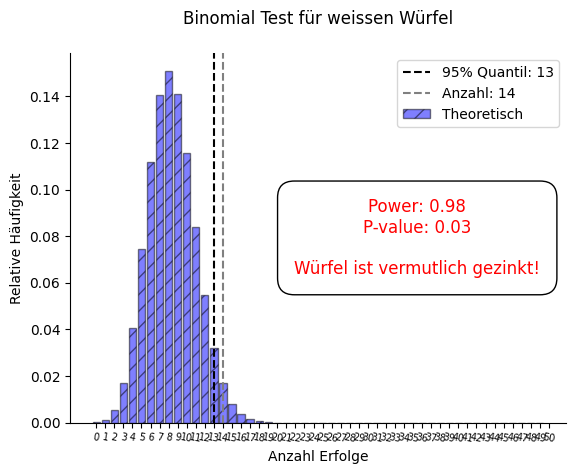

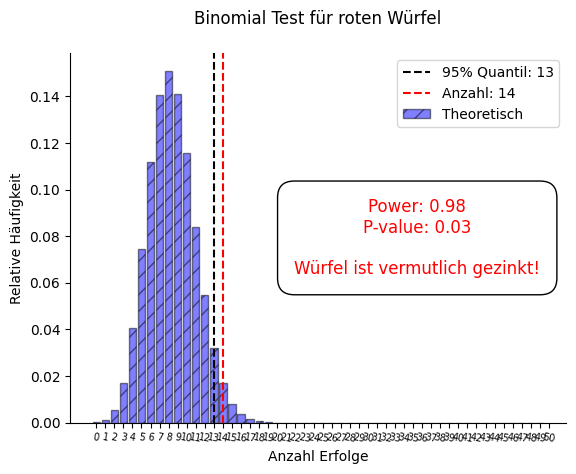

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

def plot_binomial_test(sample_size, observed, color='white', p_alt=2.5/6, alpha=0.05):
    # Define parameters
    p_true = 1/6   # Probability of success for the null hypothesis

    # Calculate critical value for significance level
    critical_value = binom.ppf(1 - alpha, sample_size, p_true)

    # Generate sequence of possible outcomes
    x = np.arange(0, sample_size)

    # Calculate probability mass function values for the null hypothesis
    density_null = binom.pmf(x, sample_size, p_true)

    # Calculate power of the test
    power = 1 - binom.cdf(observed - 1, sample_size, p_alt)

    # Calculate p-value for the observed value under the real distribution
    p_value_observed = 1 - binom.cdf(observed - 1, sample_size, p_true)

    # Plot the density function
    plt.bar(x, density_null, color='blue', hatch='//', edgecolor='black', alpha=0.5, label=f'Theoretisch')

    # Add vertical lines for critical value and observed value
    plt.axvline(x=int(critical_value), color='black', linestyle='--', label=f'95% Quantil: {int(critical_value)}')
    
    if color == 'red':
        plt.axvline(x=int(observed), color='red', linestyle='--', label=f'Anzahl: {int(observed)}')
    else:    
        plt.axvline(x=int(observed), color='grey', linestyle='--', label=f'Anzahl: {int(observed)}')
    
    
    # Add legend
    plt.legend()

    if color == 'red':
        plt.title(f'Binomial Test für roten Würfel\n')
    if color == 'white':
        plt.title(f'Binomial Test für weissen Würfel\n')
    
    plt.xlabel('Anzahl Erfolge')
    plt.ylabel('Relative Häufigkeit')
    
    # Set integer ticks for x-axis
    plt.xticks(np.arange(0, sample_size+1, step=1),fontsize=7, rotation=-10)

    # Customize the frame
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add a text box in front of the plot
    text = f'Power: {power:.2f}\n'
    text += f'P-value: {p_value_observed:.2f}\n\n'
    if p_value_observed < alpha:
        text += "Würfel ist vermutlich gezinkt!"
        text_color = 'red'
    else:
        text += "Kein Beweis für einen gefälschten Würfel!"
        text_color = 'green'
    
    plt.text(0.7, 0.5, text, transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'),
             fontsize=12, color=text_color, ha='center', va='center')

    # Show plot
    plt.show()

plot_binomial_test(sample_size=50, observed=14, color='white', p_alt=2.5/6, alpha=0.05)
plot_binomial_test(sample_size=50, observed=14, color='red', p_alt=2.5/6, alpha=0.05)

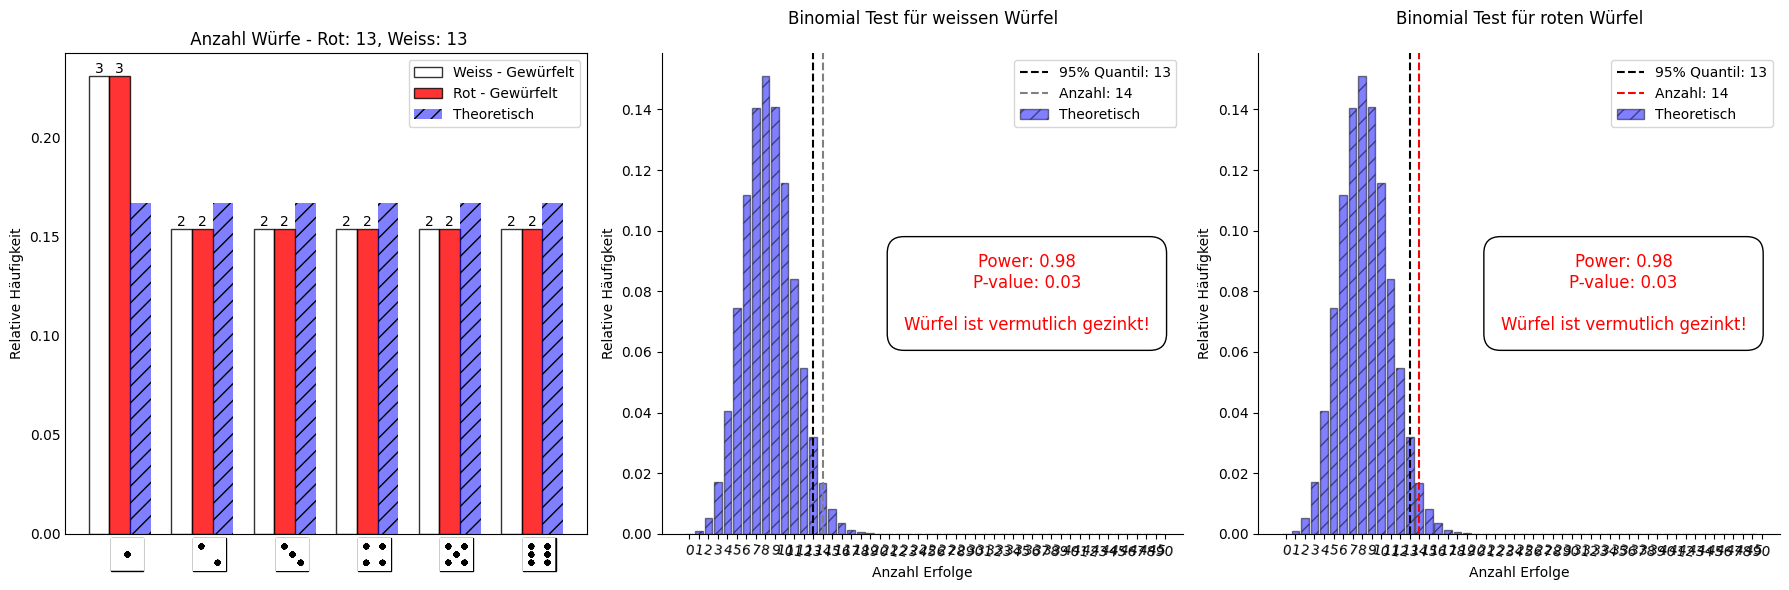

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.stats import chisquare
from matplotlib.ticker import MaxNLocator
import numpy as np
from scipy.stats import binom

# Lock matplotlib for multithreading
#plt.switch_backend('Agg')
from threading import Lock
matplotlib_lock = Lock()

STATPATH = r'C:\Users\buehl\repos\Dice\dev_app\static'

def place_image(ax, img_path, xy, zoom=1):
    img = plt.imread(img_path)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=True, xybox=(20, -15), boxcoords="offset points", pad=0)
    ax.add_artist(ab)

def plot_histogram(data_path, column_names=['white', 'red']):
    
    german_dict= {'white':'Weiss - Gewürfelt', 'red':'Rot - Gewürfelt'}
    with matplotlib_lock:
        df = pd.read_csv(data_path)
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust the figure size here
        
        # Set x-axis to integers only
        for ax in axs:
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        # Plot each column's histogram side by side
        bar_width = 0.25
        for i, column_name in enumerate(column_names):
            rolls = df[column_name].dropna().tolist()
            if len(rolls) != 0:
                # Calculate observed frequencies and p-value
                observed_frequencies = [rolls.count(i) / len(rolls) for i in range(1, 7)]
                
                # Plot bar chart for observed frequencies
                axs[0].bar([x + i * bar_width for x in range(1, 7)], 
                           observed_frequencies, 
                           alpha=0.8, label=german_dict[column_name], width=bar_width,
                           edgecolor='black',
                           color='red' if column_name == 'red' else 'white')
                
                # Annotate each bar with the actual count for each outcome
                for x, freq in zip(range(1, 7), observed_frequencies):
                    axs[0].text(x + (i * bar_width), freq + 0.0, f'{rolls.count(x)}', ha='center', va='bottom')

        # Plot theoretical probabilities (shared between both columns)
        theoretical_probs = [1/6] * 6
        axs[0].bar([x + len(column_names) * bar_width for x in range(1, 7)], 
                   theoretical_probs, 
                   alpha=0.5, label=f'Theoretisch', width=bar_width,
                   color='blue', hatch='//')

        # Remove numerical x-tick labels and place images instead
        axs[0].set_xticks([1 + i * bar_width + len(column_names) * bar_width / 2 for i in range(6)])
        axs[0].set_xticklabels([])  # Remove x-tick labels
        axs[0].tick_params(axis='both', which='both', length=0)  # Remove axis ticks

        for i in range(1, 7):
            place_image(axs[0], os.path.join(STATPATH, f'side{i}.jpg'), xy=(i, 0), zoom=0.04)
            
        len_white = len(df['white'].dropna().tolist())
        len_red = len(df['red'].dropna().tolist())
        
        axs[0].set_title(f' Anzahl Würfe - Rot: {len_white}, Weiss: {len_red}')
        axs[0].set_ylabel('Relative Häufigkeit')
        axs[0].legend()
        
        # Plot binomial tests
        plot_binomial_test(sample_size=50, observed=14, color='white', p_alt=2.5/6, alpha=0.05, ax=axs[1])
        plot_binomial_test(sample_size=50, observed=14, color='red', p_alt=2.5/6, alpha=0.05, ax=axs[2])
        
        plt.tight_layout()
        plt.show()

def plot_binomial_test(sample_size, observed, color='white', p_alt=2.5/6, alpha=0.05, ax=None):
    # Define parameters
    p_true = 1/6   # Probability of success for the null hypothesis

    # Calculate critical value for significance level
    critical_value = binom.ppf(1 - alpha, sample_size, p_true)

    # Generate sequence of possible outcomes
    x = np.arange(0, sample_size)

    # Calculate probability mass function values for the null hypothesis
    density_null = binom.pmf(x, sample_size, p_true)

    # Calculate power of the test
    power = 1 - binom.cdf(observed - 1, sample_size, p_alt)

    # Calculate p-value for the observed value under the real distribution
    p_value_observed = 1 - binom.cdf(observed - 1, sample_size, p_true)

    # Plot the density function
    ax.bar(x, density_null, color='blue', hatch='//', edgecolor='black', alpha=0.5, label=f'Theoretisch')

    # Add vertical lines for critical value and observed value
    ax.axvline(x=int(critical_value), color='black', linestyle='--', label=f'95% Quantil: {int(critical_value)}')
    
    if color == 'red':
        ax.axvline(x=int(observed), color='red', linestyle='--', label=f'Anzahl: {int(observed)}')
    else:    
        ax.axvline(x=int(observed), color='grey', linestyle='--', label=f'Anzahl: {int(observed)}')
    
    
    # Add legend
    ax.legend()

    if color == 'red':
        ax.set_title(f'Binomial Test für roten Würfel\n')
    if color == 'white':
        ax.set_title(f'Binomial Test für weissen Würfel\n')
    
    ax.set_xlabel('Anzahl Erfolge')
    ax.set_ylabel('Relative Häufigkeit')
    
    # Set integer ticks for x-axis
    ax.set_xticks(np.arange(0, sample_size+1, step=1))
    ax.tick_params(axis='x', labelrotation=-10)

    # Customize the frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add a text box in front of the plot
    text = f'Power: {power:.2f}\n'
    text += f'P-value: {p_value_observed:.2f}\n\n'
    if p_value_observed < alpha:
        text += "Würfel ist vermutlich gezinkt!"
        text_color = 'red'
    else:
        text += "Kein Beweis für einen gefälschten Würfel!"
        text_color = 'green'
    
    ax.text(0.7, 0.5, text, transform=ax.transAxes,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'),
             fontsize=12, color=text_color, ha='center', va='center')

# Plot the combined figure
plot_histogram('results.csv', ['white', 'red'])


In [46]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import MaxNLocator
import numpy as np
from scipy.stats import binom
from matplotlib import gridspec

# Lock matplotlib for multithreading
#plt.switch_backend('Agg')
from threading import Lock
matplotlib_lock = Lock()

STATPATH = r'C:\Users\buehl\repos\Dice\dev_app\static'

def place_image(ax, img_path, xy, zoom=1):
    img = plt.imread(img_path)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=True, xybox=(20, -15), boxcoords="offset points", pad=0)
    ax.add_artist(ab)

def plot_histogram(ax, df, column_names=['white', 'red']):
    german_dict = {'white':'Weiss - Gewürfelt', 'red':'Rot - Gewürfelt'}
    
    # Set x-axis to integers only
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Plot each column's histogram side by side
    bar_width = 0.25
    for i, column_name in enumerate(column_names):
        rolls = df[column_name].dropna().tolist()
        if len(rolls) != 0:
            # Calculate observed frequencies and p-value
            observed_frequencies = [rolls.count(i) / len(rolls) for i in range(1, 7)]

            # Plot bar chart for observed frequencies
            ax.bar([x + i * bar_width for x in range(1, 7)], 
                   observed_frequencies, 
                   alpha=0.8, label=german_dict[column_name], width=bar_width,
                   edgecolor='black',
                   color='red' if column_name == 'red' else 'white')

            # Annotate each bar with the actual count for each outcome
            for x, freq in zip(range(1, 7), observed_frequencies):
                ax.text(x + (i * bar_width), freq + 0.0, f'{rolls.count(x)}', ha='center', va='bottom')

    # Plot theoretical probabilities (shared between both columns)
    theoretical_probs = [1/6] * 6
    ax.bar([x + len(column_names) * bar_width for x in range(1, 7)], 
           theoretical_probs, 
           alpha=0.5, label=f'Theoretisch', width=bar_width,
           color='blue', hatch='//')

    # Remove numerical x-tick labels and place images instead
    ax.set_xticks([1 + i * bar_width + len(column_names) * bar_width / 2 for i in range(6)])
    ax.set_xticklabels([])  # Remove x-tick labels
    ax.tick_params(axis='both', which='both', length=0)  # Remove axis ticks

    for i in range(1, 7):
        place_image(ax, os.path.join(STATPATH, f'side{i}.jpg'), xy=(i, 0), zoom=0.04)

    len_white = len(df['white'].dropna().tolist())
    len_red = len(df['red'].dropna().tolist())

    ax.set_title(f' Anzahl Würfe - Rot: {len_white}, Weiss: {len_red}')
    ax.set_ylabel('Relative Häufigkeit')
    ax.legend()
    
def plot_binomial_test(sample_size, observed, color='white', p_alt=2.5/6, alpha=0.05, ax=None):
    # Define parameters
    p_true = 1/6   # Probability of success for the null hypothesis

    # Calculate critical value for significance level
    critical_value = binom.ppf(1 - alpha, sample_size, p_true)

    # Generate sequence of possible outcomes
    x = np.arange(0, sample_size)

    # Calculate probability mass function values for the null hypothesis
    density_null = binom.pmf(x, sample_size, p_true)

    # Calculate power of the test
    power = 1 - binom.cdf(observed - 1, sample_size, p_alt)

    # Calculate p-value for the observed value under the real distribution
    p_value_observed = 1 - binom.cdf(observed - 1, sample_size, p_true)

    # Plot the density function
    ax.bar(x, density_null, color='blue', hatch='//', edgecolor='black', alpha=0.5, label=f'Theoretisch')

    # Add vertical lines for critical value and observed value
    ax.axvline(x=int(critical_value), color='black', linestyle='--', label=f'95% Quantil: {int(critical_value)}')
    
    if color == 'red':
        ax.axvline(x=int(observed), color='red', linestyle='--', label=f'Anzahl: {int(observed)}')
    else:    
        ax.axvline(x=int(observed), color='grey', linestyle='--', label=f'Anzahl: {int(observed)}')
    
    
    # Add legend
    ax.legend()

    if color == 'red':
        ax.set_title(f'Binomial Test Rot Nr. 3\n')
    if color == 'white':
        ax.set_title(f'Binomial Test Weiss Nr. 6\n')
    
    ax.set_xlabel('Anzahl Erfolge')
    ax.set_ylabel('Relative Häufigkeit')
    
    # Set integer ticks for x-axis
    ax.set_xticks(np.arange(0, sample_size+1, step=1))
    ax.tick_params(axis='x')

    # Customize the frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add a text box in front of the plot
    text = f'Power: {power:.2f}\n'
    text += f'P-value: {p_value_observed:.2f}\n\n'
    if p_value_observed < alpha:
        text += "Würfel ist vermutlich gezinkt!"
        text_color = 'red'
    else:
        text += "Kein Beweis für einen gefälschten Würfel!"
        text_color = 'green'
    
    ax.text(0.72, 0.3, text, transform=ax.transAxes,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'),
             fontsize=12, color=text_color, ha='center', va='center')


def plot_histogram_and_binomial_tests(data_path):
    
    with matplotlib_lock:
        fig = plt.figure(figsize=(20, 8))  # Adjust the figure size here
        gs = gridspec.GridSpec(2, 2, width_ratios=[1.5, 1], height_ratios=[1, 1])  # Custom grid layout
        
        #count 6es and 3s
        df = pd.read_csv(data_path)
        white_list,red_list = df['white'].dropna().tolist(), df['red'].dropna().tolist()
        
        white_6=  white_list.count(6)
        red_3= red_list.count(3)
        
        ax_histogram = plt.subplot(gs[:, 0])
        plot_histogram(ax_histogram, df)
        
        ax_white_test = plt.subplot(gs[0, 1])
        ax_red_test = plt.subplot(gs[1, 1])
        

        # TODO : change the real probas
        
        if white_6 > 0:
            plot_binomial_test(sample_size=len(white_list), observed=white_6, color='white', p_alt=2.5/6, alpha=0.05, ax=ax_white_test)
        else:
            ax_white_test.axis('off')
        
        if red_3 > 0:
            plot_binomial_test(sample_size=len(red_list), observed=red_3, color='red', p_alt=2.5/6, alpha=0.05, ax=ax_red_test)
        else:
            ax_red_test.axis('off')
                    
        plt.tight_layout()
        plt.show()





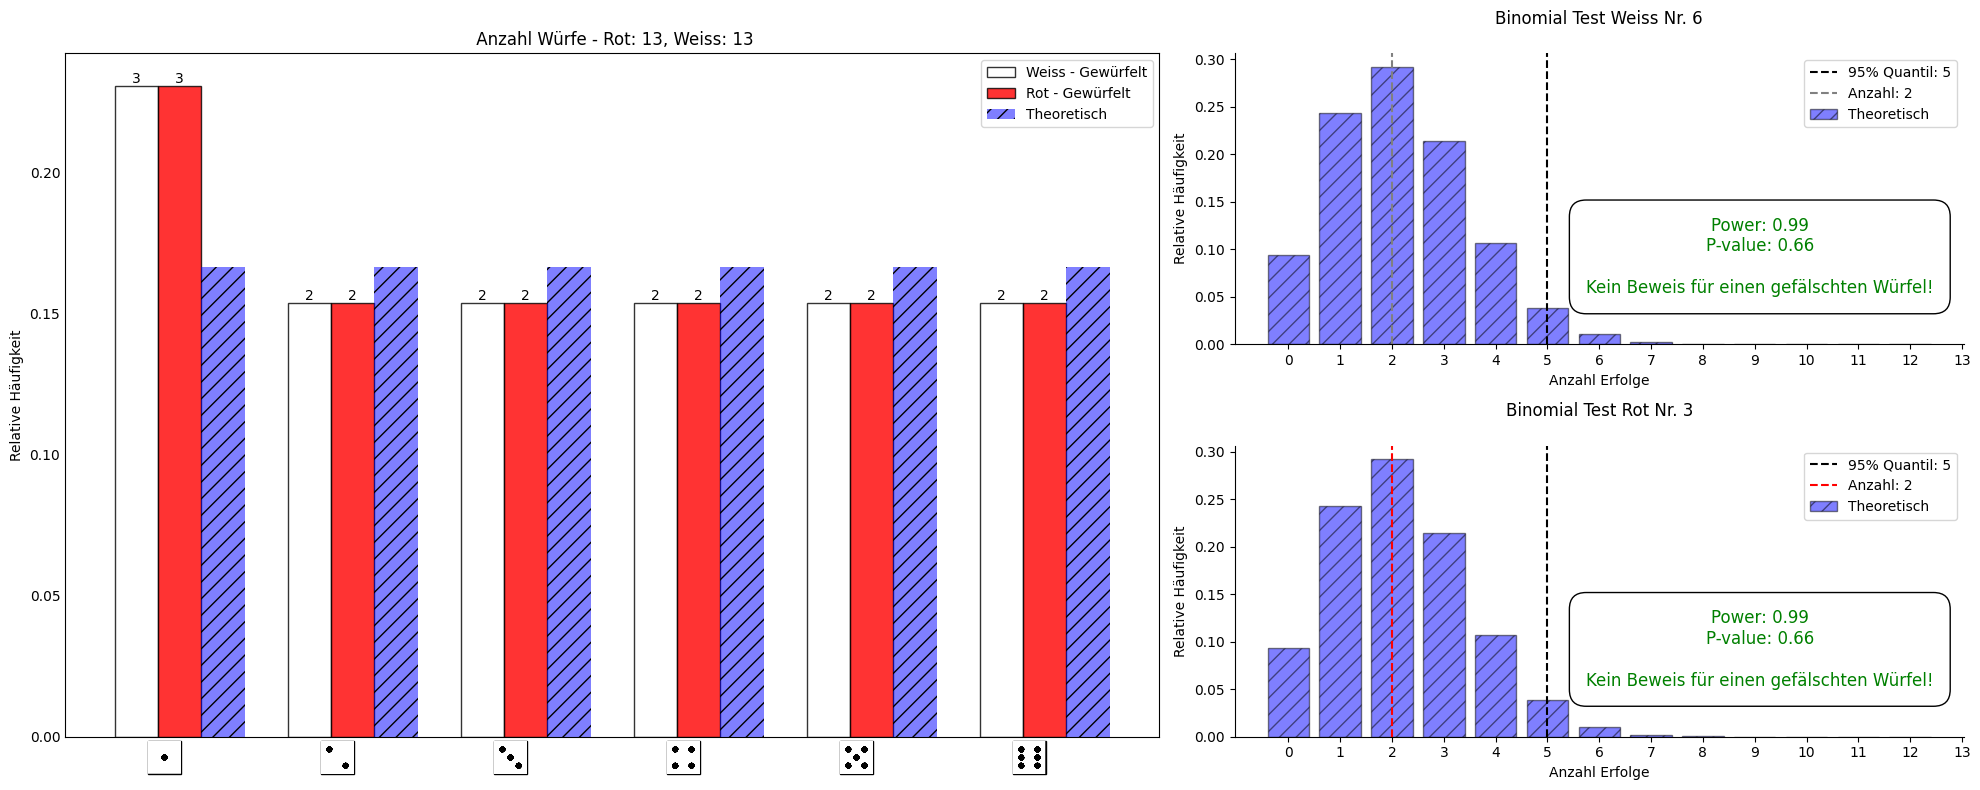

In [47]:
# Plot the combined figure
plot_histogram_and_binomial_tests('results.csv')

## Recoridng mechanism for frameloop

In [36]:

def append_to_csv(filepath, new_df):
    existing_df = pd.read_csv(filepath)
    updated_df = pd.concat([existing_df, new_df], ignore_index=True)
    updated_df.to_csv(filepath, index=False)

def check_empty_dice_results(filepath):
    df = pd.read_csv(filepath)
    if df.empty:
        return True
    return False

def create_dataframe_fillNA(data:dict):
    ''' Create a DataFrame from a dictionary and fill missing values with NaN'''
    max_length = max(len(values) for values in data.values())
    for key, values in data.items():
        data[key] = values + [None] * (max_length - len(values))
    return pd.DataFrame(data)

def dummy_dice_pred():
    dice_dict = {"white": [], "red": []}
    
    for color in dice_dict:
        num_numbers = 1 #random.randint(0, 5)  # Randomly select the number of numbers to add
        numbers = [random.randint(1, 6) for _ in range(num_numbers)]  # Generate random numbers
        dice_dict[color] = numbers
    
    return dice_dict , True

def write_res(dice_prediction, filepath='result/results.csv'):
    dice_dict, dice_pass = dice_prediction
    if not dice_pass:
        dice_msg="Dice: Prediction failed, try again!"
    
    else:
        if check_empty_dice_results(filepath):
            throw_number=0
            print("First throw")
        throw_number += 1
        
        dice_dict_NA=create_dataframe_fillNA(dice_dict)
        dice_dict_NA['throw'] = [throw_number] * len(dice_dict['white'])
        
        append_to_csv(filepath, dice_dict_NA)
        
        dice_msg="Dice: "+str(dice_dict)
        
    return dice_msg 

## with go 

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.stats import chisquare
from io import BytesIO

def plot_histogram(df, column_name):
    rolls = df[column_name].dropna()
    observed_frequencies = [rolls.tolist().count(i) for i in range(1, 7)]
    expected_frequencies = [len(rolls) / 6] * 6

    p_value = 0
    if len(rolls) != 0:
        chi_squared_stat, p_value = chisquare(observed_frequencies, f_exp=expected_frequencies)

    # Create the plot
    fig = go.Figure()

    # Plotting the bar charts
    fig.add_trace(go.Bar(x=np.arange(1, 7), y=[1/6]*6, name='Theoretisch', marker_color='#0165A8'))

    if len(rolls) != 0 and column_name == 'red':
        fig.add_trace(go.Bar(x=np.arange(1, 7), y=observed_frequencies/np.sum(observed_frequencies),
                             name='Gewürfelt', marker_color='red'))
    elif len(rolls) != 0 and column_name == 'white':
        fig.add_trace(go.Bar(x=np.arange(1, 7), y=observed_frequencies/np.sum(observed_frequencies),
                             name='Gewürfelt', marker_color='white', marker_line_color='black'))

    # Update x-axis and y-axis labels
    fig.update_xaxes(title_text='Würfel Augen')
    fig.update_yaxes(title_text='Relative Häufigkeit')

    # Set title
    fig.update_layout(title=f'Häufigkeiten von Würfelergebnissen, Anzahl Würfe: {len(rolls)} p= {p_value:.3f}',
                      barmode='group', legend=dict(x=0.7, y=1))

    
    fig.show()
    # # Save the plot to an image
    # img_bytes = fig.to_image(format="png")

    # return BytesIO(img_bytes)

# Load the DataFrame
df = pd.read_csv(r'C:\Users\buehl\repos\Dice\rasperry_run\results\results.csv')

# Plot histogram for 'white' and 'red' columns
plot_histogram(df, column_name='white')
plot_histogram(df, column_name='red')


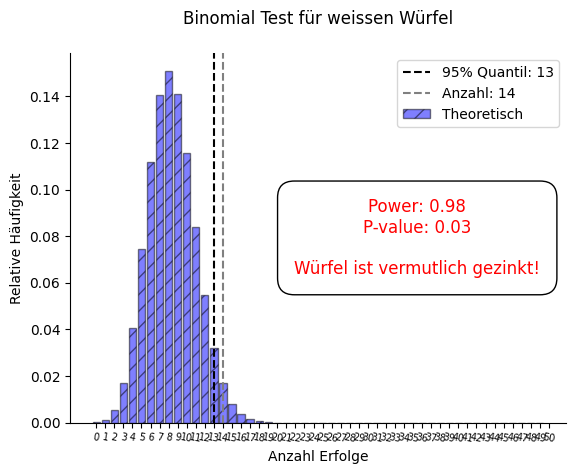

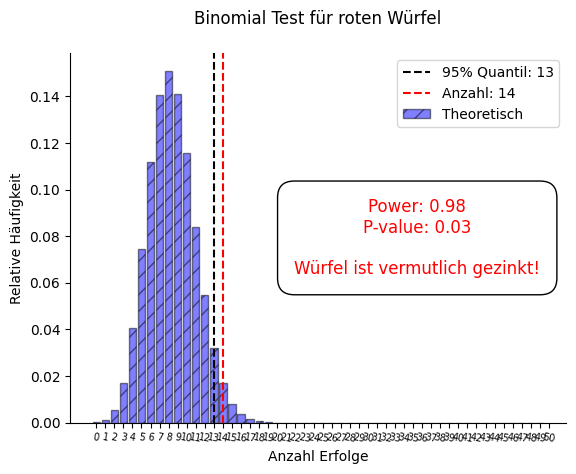

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

def plot_binomial_test(sample_size, observed, color='white', p_alt=2.5/6, alpha=0.05):
    # Define parameters
    p_true = 1/6   # Probability of success for the null hypothesis

    # Calculate critical value for significance level
    critical_value = binom.ppf(1 - alpha, sample_size, p_true)

    # Generate sequence of possible outcomes
    x = np.arange(0, sample_size)

    # Calculate probability mass function values for the null hypothesis
    density_null = binom.pmf(x, sample_size, p_true)

    # Calculate power of the test
    power = 1 - binom.cdf(observed - 1, sample_size, p_alt)

    # Calculate p-value for the observed value under the real distribution
    p_value_observed = 1 - binom.cdf(observed - 1, sample_size, p_true)

    # Plot the density function
    plt.bar(x, density_null, color='blue', hatch='//', edgecolor='black', alpha=0.5, label=f'Theoretisch')

    # Add vertical lines for critical value and observed value
    plt.axvline(x=int(critical_value), color='black', linestyle='--', label=f'95% Quantil: {int(critical_value)}')
    
    if color == 'red':
        plt.axvline(x=int(observed), color='red', linestyle='--', label=f'Anzahl: {int(observed)}')
    else:    
        plt.axvline(x=int(observed), color='grey', linestyle='--', label=f'Anzahl: {int(observed)}')
    
    
    # Add legend
    plt.legend()

    if color == 'red':
        plt.title(f'Binomial Test für roten Würfel\n')
    if color == 'white':
        plt.title(f'Binomial Test für weissen Würfel\n')
    
    plt.xlabel('Anzahl Erfolge')
    plt.ylabel('Relative Häufigkeit')
    
    # Set integer ticks for x-axis
    plt.xticks(np.arange(0, sample_size+1, step=1),fontsize=7, rotation=-10)

    # Customize the frame
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add a text box in front of the plot
    text = f'Power: {power:.2f}\n'
    text += f'P-value: {p_value_observed:.2f}\n\n'
    if p_value_observed < alpha:
        text += "Würfel ist vermutlich gezinkt!"
        text_color = 'red'
    else:
        text += "Kein Beweis für einen gefälschten Würfel!"
        text_color = 'green'
    
    plt.text(0.7, 0.5, text, transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'),
             fontsize=12, color=text_color, ha='center', va='center')

    # Show plot
    plt.show()

plot_binomial_test(sample_size=50, observed=14, color='white', p_alt=2.5/6, alpha=0.05)
plot_binomial_test(sample_size=50, observed=14, color='red', p_alt=2.5/6, alpha=0.05)